In [45]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, f1_score, precision_score,
                             recall_score, roc_auc_score, silhouette_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     ShuffleSplit, StratifiedShuffleSplit,
                                     cross_val_score)
import eli5
from eli5.sklearn import PermutationImportance


In [46]:
IMAGES_PATH = ""

In [47]:
def concat_two_df_and_drop_same_column_in_df2(DF1, DF2):
    display(DF1.head(1))
    display(DF2.head(1))
    DF2.drop(DF2.columns[DF2.columns.isin(DF1.columns)],axis=1,inplace=True)
#     DF1.drop(DF1.columns[DF1.columns.isin(DF2.columns)],axis=1,inplace=True)
    result = pd.concat([DF1, DF2], axis=1)
    display(result.head(1))
    return result
def count_list_val(arr):
    values, counts = np.unique(arr, return_counts=True)
    print(values, counts)

In [48]:
four_time = pd.read_csv("../CSV/four_time.csv")
v_value = pd.read_csv("../CSV/v_value.csv")
mic = pd.read_csv("../CSV/mic.csv")
dwt_distance = pd.read_csv("../CSV/sdtw_day_score_df.csv")
smart_meter = pd.read_csv("../smart_meter.csv")

In [49]:
fdi = pd.read_csv("../CSV/FDI.csv")

In [51]:
four_time.shape, v_value.shape, mic.shape, dwt_distance.shape, smart_meter.shape

((2239250, 7), (2239250, 9), (2239250, 4), (2239250, 5), (107484000, 5))

In [12]:
result = concat_two_df_and_drop_same_column_in_df2(fdi, v_value)
result = concat_two_df_and_drop_same_column_in_df2(result, four_time)
result = concat_two_df_and_drop_same_column_in_df2(result, mic)
result = concat_two_df_and_drop_same_column_in_df2(result, dwt_distance)
result.columns

,MeterID,Day,FDI
0,1236,2009-07-15,1.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,overnight,breakfast,daytime,evening
0,1236,2009-07-15,True,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,mic
0,1236,2009-07-15,True,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,meter_dtw,meter_sdtw
0,1236,2009-07-15,True,2.283294,-68.276715


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


Index(['MeterID', 'Day', 'FDI', 'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2',
       'Cmin1', 'overnight', 'breakfast', 'daytime', 'evening', 'mic',
       'meter_dtw', 'meter_sdtw'],
      dtype='object')

In [13]:
df = result
X = df[['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]
# y_train = np.array(Y[:partition]).reshape(-1) 
# y_val = np.array(Y[partition:total-evaluation]).reshape(-1) 
# y_test = np.array(Y[total-evaluation: total]).reshape(-1) 

In [14]:
count_list_val(Y)

[0. 1.] [2127950  111300]


### read smart_meter.csv and preprocess

In [28]:
elec = smart_meter['Electricity']
elec = np.array(elec).reshape(-1, 48)
elec = pd.DataFrame(elec)
print(elec.shape)
display(elec.head(3))

(2239250, 48)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.13407,0.129562,0.113616,0.18602,0.075942,0.133117,0.062728,0.064174,0.143932,0.142687,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674
1,0.48300,0.062000,0.035000,0.06800,0.026000,0.013000,0.063000,0.063000,0.013000,0.013000,...,0.138000,0.099000,0.118000,0.16400,0.218000,0.412000,0.253000,0.61000,0.582000,0.292000
2,0.11400,0.041000,0.012000,0.04000,0.067000,0.017000,0.012000,0.064000,0.058000,0.012000,...,0.110000,0.104000,0.164000,0.40100,0.104000,0.138000,0.206000,0.36300,0.526000,0.326000


In [25]:
result = concat_two_df_and_drop_same_column_in_df2(result, elec)
result.columns = result.columns.astype(str)

,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,...,38,39,40,41,42,43,44,45,46,47
0,1236,2009-07-15,1,12,30,15,0.046464,0.047532,0.013561,5.380015,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.13407,0.129562,0.113616,0.18602,0.075942,0.133117,0.062728,0.064174,0.143932,0.142687,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,...,38,39,40,41,42,43,44,45,46,47
0,1236,2009-07-15,1,12,30,15,0.046464,0.047532,0.013561,5.380015,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674


## Start Model Training 

In [17]:
result["FDI"] = result["FDI"].astype(int)

In [18]:
partition = 422*8*530
evaluation = 422*1*530
total = 2239250

X_train = X[:partition+evaluation]
y_train = Y[:partition+evaluation]
X_val = result.drop(['Day', 'MeterID', 'FDI'], axis=1)[partition:]
y_val = result['FDI'][partition:]

In [38]:
def train_model(df, x_col, y_col, score = False, split_num = 3, return_model=False ):
    
    X = df[x_col]
    Y = df[y_col]

    partition = 422*8*530
    evaluation = 422*1*530
    total = 2239250

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:partition+evaluation]
    y_train = Y[:partition+evaluation]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.4, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
#         test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = AdaBoostClassifier()
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    if return_model==True:
        return model, average_score
    return average_score

def get_permutation_importance(model, X_val, y_val, title=None, origin=False, save=False):
    
    if save_fig == True and title == None:
        raise NameError('Please type the title for the chart to save')
        
    r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)
    four_time_importance = sum(r.importances_mean[:3])
    mic_importance = r.importances_mean[10]
    v_value_importance = sum(r.importances_mean[4:10])
    dtw_importance = r.importances_mean[11]
    sdtw_importance = r.importances_mean[12]
    if origin == True:
        print('include origin data')
        origin_importance = sum(r.importances_mean[13:])
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance,
                  "dtw": dtw_importance, "sdtw": sdtw_importance, 'origin':origin_importance}
    else:
        print('no origin data')
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance, "dtw": dtw_importance, "sdtw": sdtw_importance}
    
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')
    
    if save == True:
        save_fig('Permutation importance: '+ title)
        
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [36]:
def save_importance(importance, title, size=(10,10)):
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))
    
    
    plt.rcdefaults()
#     fig, ax = plt.subplots()
    plt.figure(dpi=150, figsize=size)
    plt.barh(y_pos, list(importance.values()), align='center')

#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(y_label)
    plt.yticks(y_pos, y_label)
    plt.xlabel('Importance Mean')
#     ax.set_xlabel('Importance Mean')
#     ax.set_title('Permutation importance')
    plt.title('Permutation importance')

    save_fig('Permutation importance: '+ title)
def plot_importance(importance):
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')

In [31]:
# 6:4 and seperate train and test dataset
# 48 features only
TITLE = "Adaboost: 48 features with 0.4 test data"
col = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47']
model, score = train_model(result, col, ['FDI'], return_model=True)

r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

save_importance(importance_dict, "adaboost with 48 features", size=(8,10))

average_precision_score: 0.7487757155942364
average_recall_score: 0.1521496788792386
average_accuracy_score: 0.9552673369963006
average_roc_auc_score: 0.5747377732999371
average_f1_score: 0.25290611217468534
0:  [-1.16110305e-05 -1.20576086e-05 -1.07178743e-05] -1.1462171113881444e-05
1:  [-8.93156191e-06 -1.47370771e-05 -1.87562800e-05] -1.41416396859384e-05
2:  [-1.25041867e-05 -1.42904991e-05 -1.25041867e-05] -1.3099624130097354e-05
3:  [0. 0. 0.] 0.0
4:  [0. 0. 0.] 0.0
5:  [0. 0. 0.] 0.0
6:  [0. 0. 0.] 0.0
7:  [-5.35893714e-06 -1.42904991e-05 -1.20576086e-05] -1.056901492317112e-05
8:  [-2.00960143e-05 -2.54549514e-05 -2.32220610e-05] -2.292434222772588e-05
9:  [-3.88522943e-05 -3.26002010e-05 -2.94741543e-05] -3.364221651599072e-05
10:  [-4.59975438e-05 -4.42112314e-05 -5.00167467e-05] -4.674184064608807e-05
11:  [-1.65233895e-05 -1.74165457e-05 -1.92028581e-05] -1.7714264448668676e-05
12:  [0. 0. 0.] 0.0
13:  [-4.59975438e-05 -3.43865133e-05 -4.28714972e-05] -4.108518477171271e-0

NameError: name 'plot_importance' is not defined

Saving figure Permutation importance: adaboost with 48 features


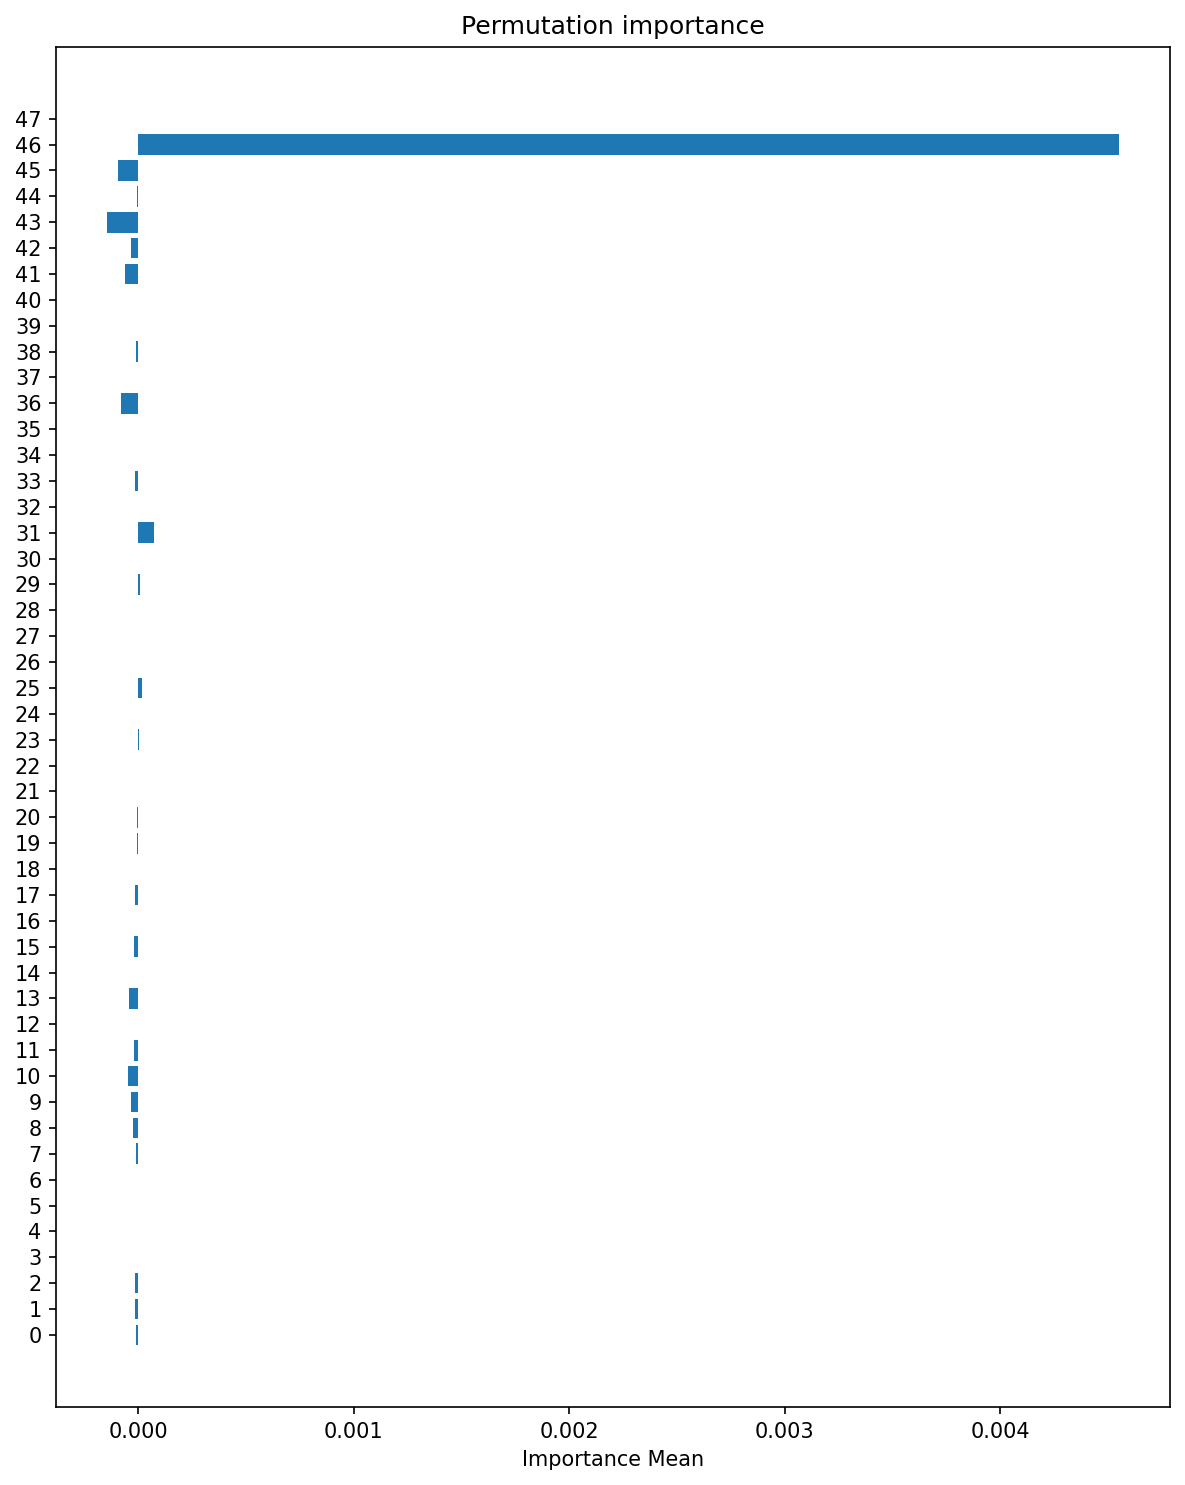

In [39]:
# plot_importance(importance_dict)
save_importance(importance_dict, "adaboost with 48 features", size=(8,10))

average_precision_score: 0.8637606688356149
average_recall_score: 0.17063492063492067
average_accuracy_score: 0.9573890263329591
average_roc_auc_score: 0.5846127667752851
average_f1_score: 0.28497332453117974
Tmax1:  [5.80551524e-06 1.02712962e-05 1.38439210e-05] 9.973577462722242e-06
Tmax2:  [2.14357486e-05 2.23289048e-05 2.67946857e-06] 1.5481373972003887e-05
Tmin1:  [3.17070448e-05 5.31427933e-05 3.52796695e-05] 4.004316921590867e-05
Cmax1:  [2.54549514e-05 2.32220610e-05 4.46578095e-07] 1.6374530162677203e-05
Cmax2:  [-4.86770124e-05 -6.38606676e-05 -5.09099029e-05] -5.448252763199749e-05
Cmin1:  [0.00045462 0.00041353 0.0004171 ] 0.00042841725280048
overnight:  [0.00185464 0.00185821 0.00184973] 0.0018541922518700755
breakfast:  [3.66194038e-05 3.66194038e-05 3.48330914e-05] 3.6023966357823234e-05
daytime:  [0. 0. 0.] 0.0
evening:  [0.00014558 0.00014603 0.00014782] 0.00014647761527301442
mic:  [0.00063503 0.0006328  0.00063682] 0.0006348851922146995
meter_dtw:  [ 1.25041867e-05 -

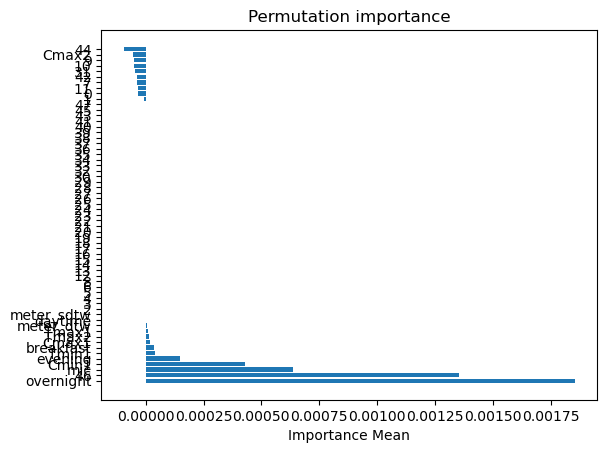

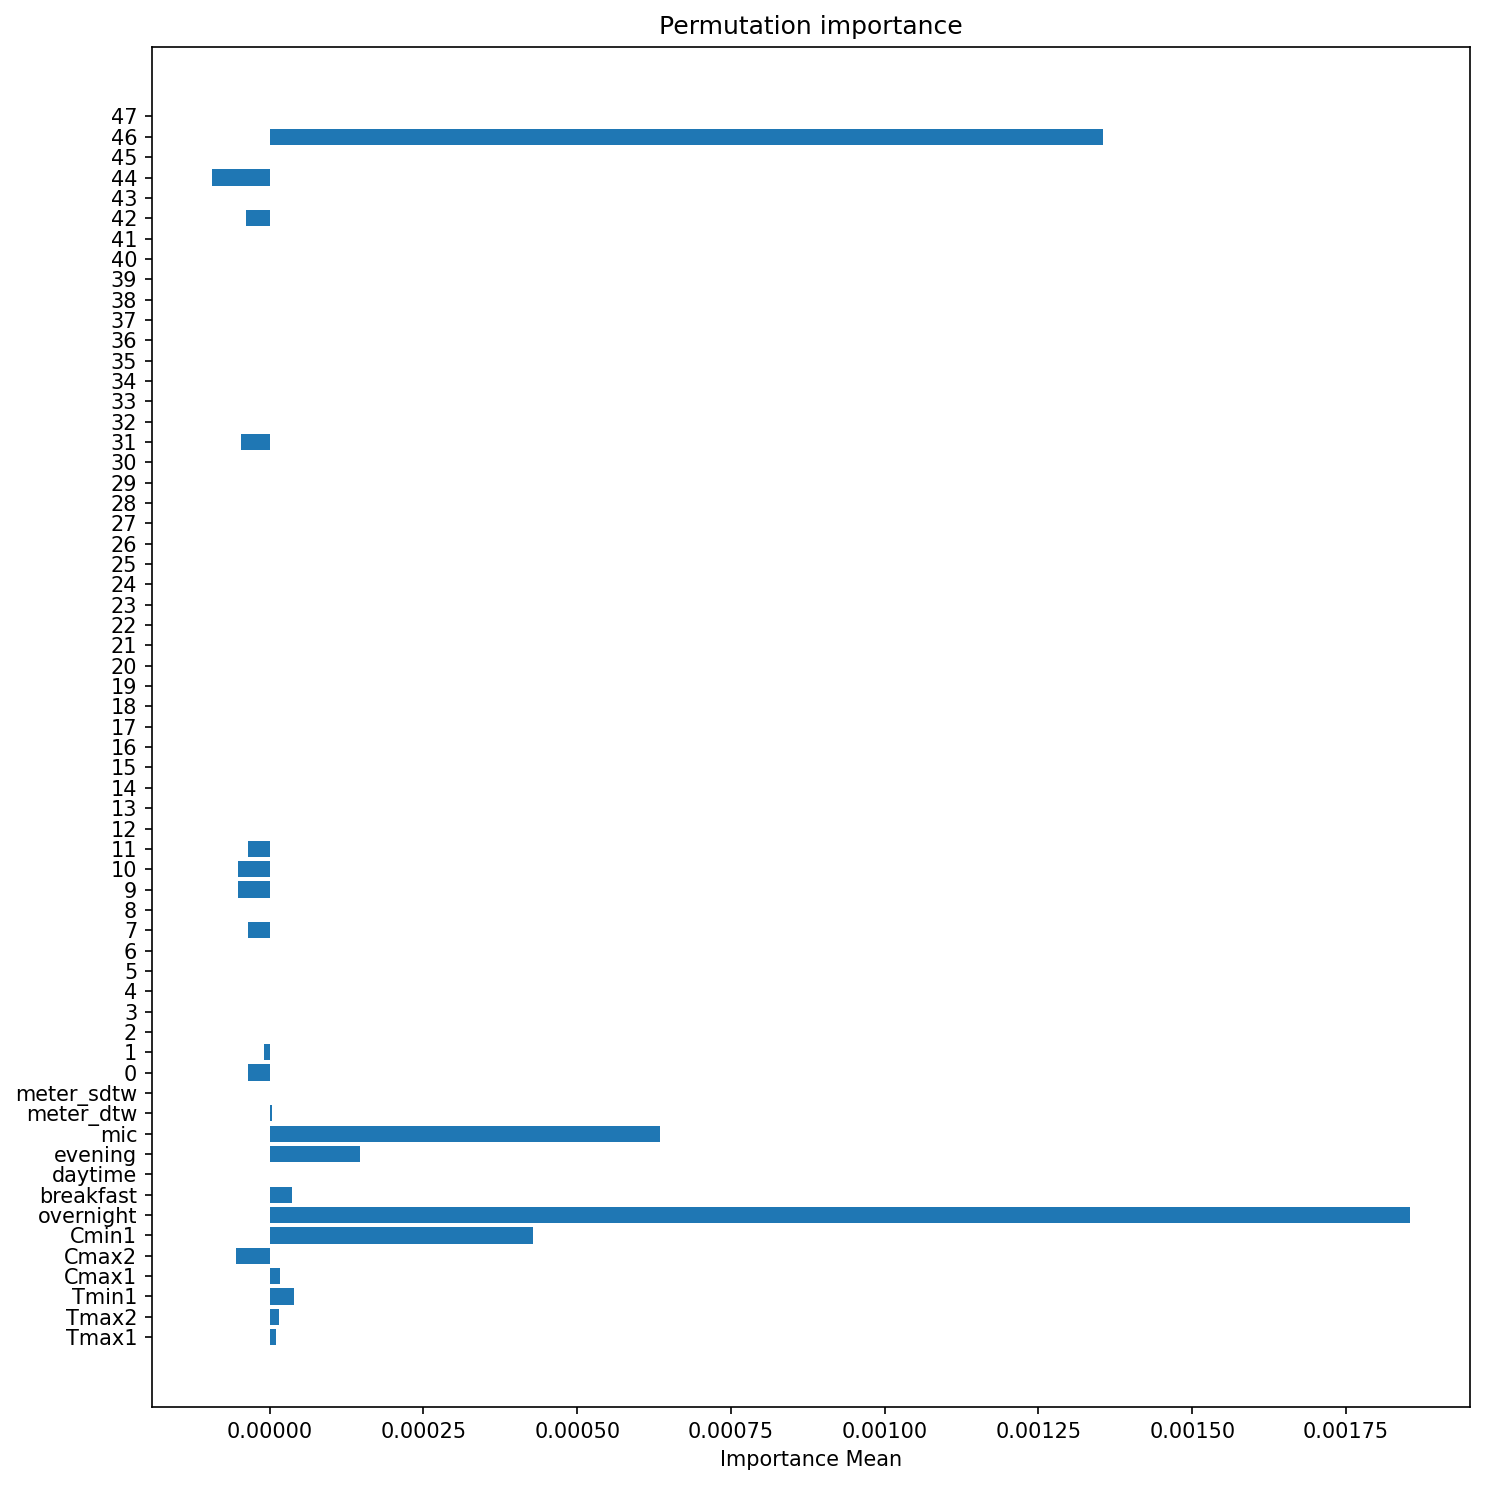

In [40]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "Adaboost: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)

r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

save_importance(importance_dict, "adaboost with 13 + 48 features", size=(10,10))

average_precision_score: 0.8553377214977128
average_recall_score: 0.1507603740308143
average_accuracy_score: 0.9564699726105431
average_roc_auc_score: 0.5747123074480781
average_f1_score: 0.25633220056221606
overnight:  [0.0012071  0.00120085 0.00119772] 0.0012018905139370057
breakfast:  [0.00662454 0.00656068 0.00657765] 0.006587622343790733
daytime:  [-0.00015228 -0.00017015 -0.0001563 ] -0.00015957723940303778
evening:  [-9.51211343e-05 -8.12772134e-05 -7.94909010e-05] -8.529641621076352e-05
Tmax1:  [3.57262476e-06 8.03840572e-06 4.46578095e-07] 4.019202858122443e-06
Tmax2:  [-5.35893714e-05 -4.28714972e-05 -6.25209333e-05] -5.29939339808753e-05
Tmin1:  [-1.25041867e-05 -8.48498381e-06 -6.69867143e-06] -9.229280637142642e-06
Cmax1:  [-0.0001438  -0.00013174 -0.00013755] -0.00013769491273118994
Cmax2:  [-2.54549514e-05 -4.73372781e-05 -4.73372781e-05] -4.004316921583465e-05
Cmin1:  [0.00063503 0.00065022 0.00064531] 0.0006435190353913193
mic:  [0.00074355 0.00076186 0.00076454] 0.000

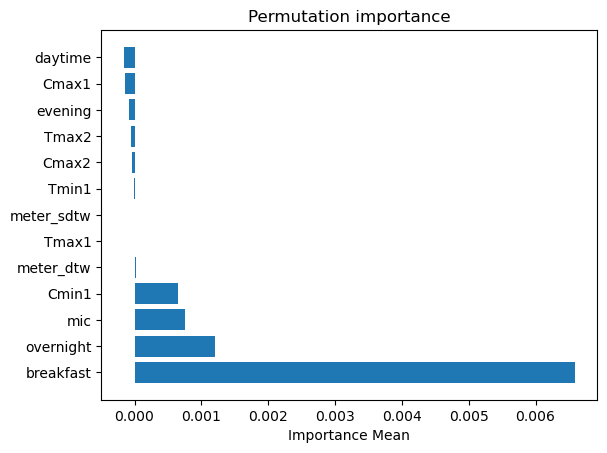

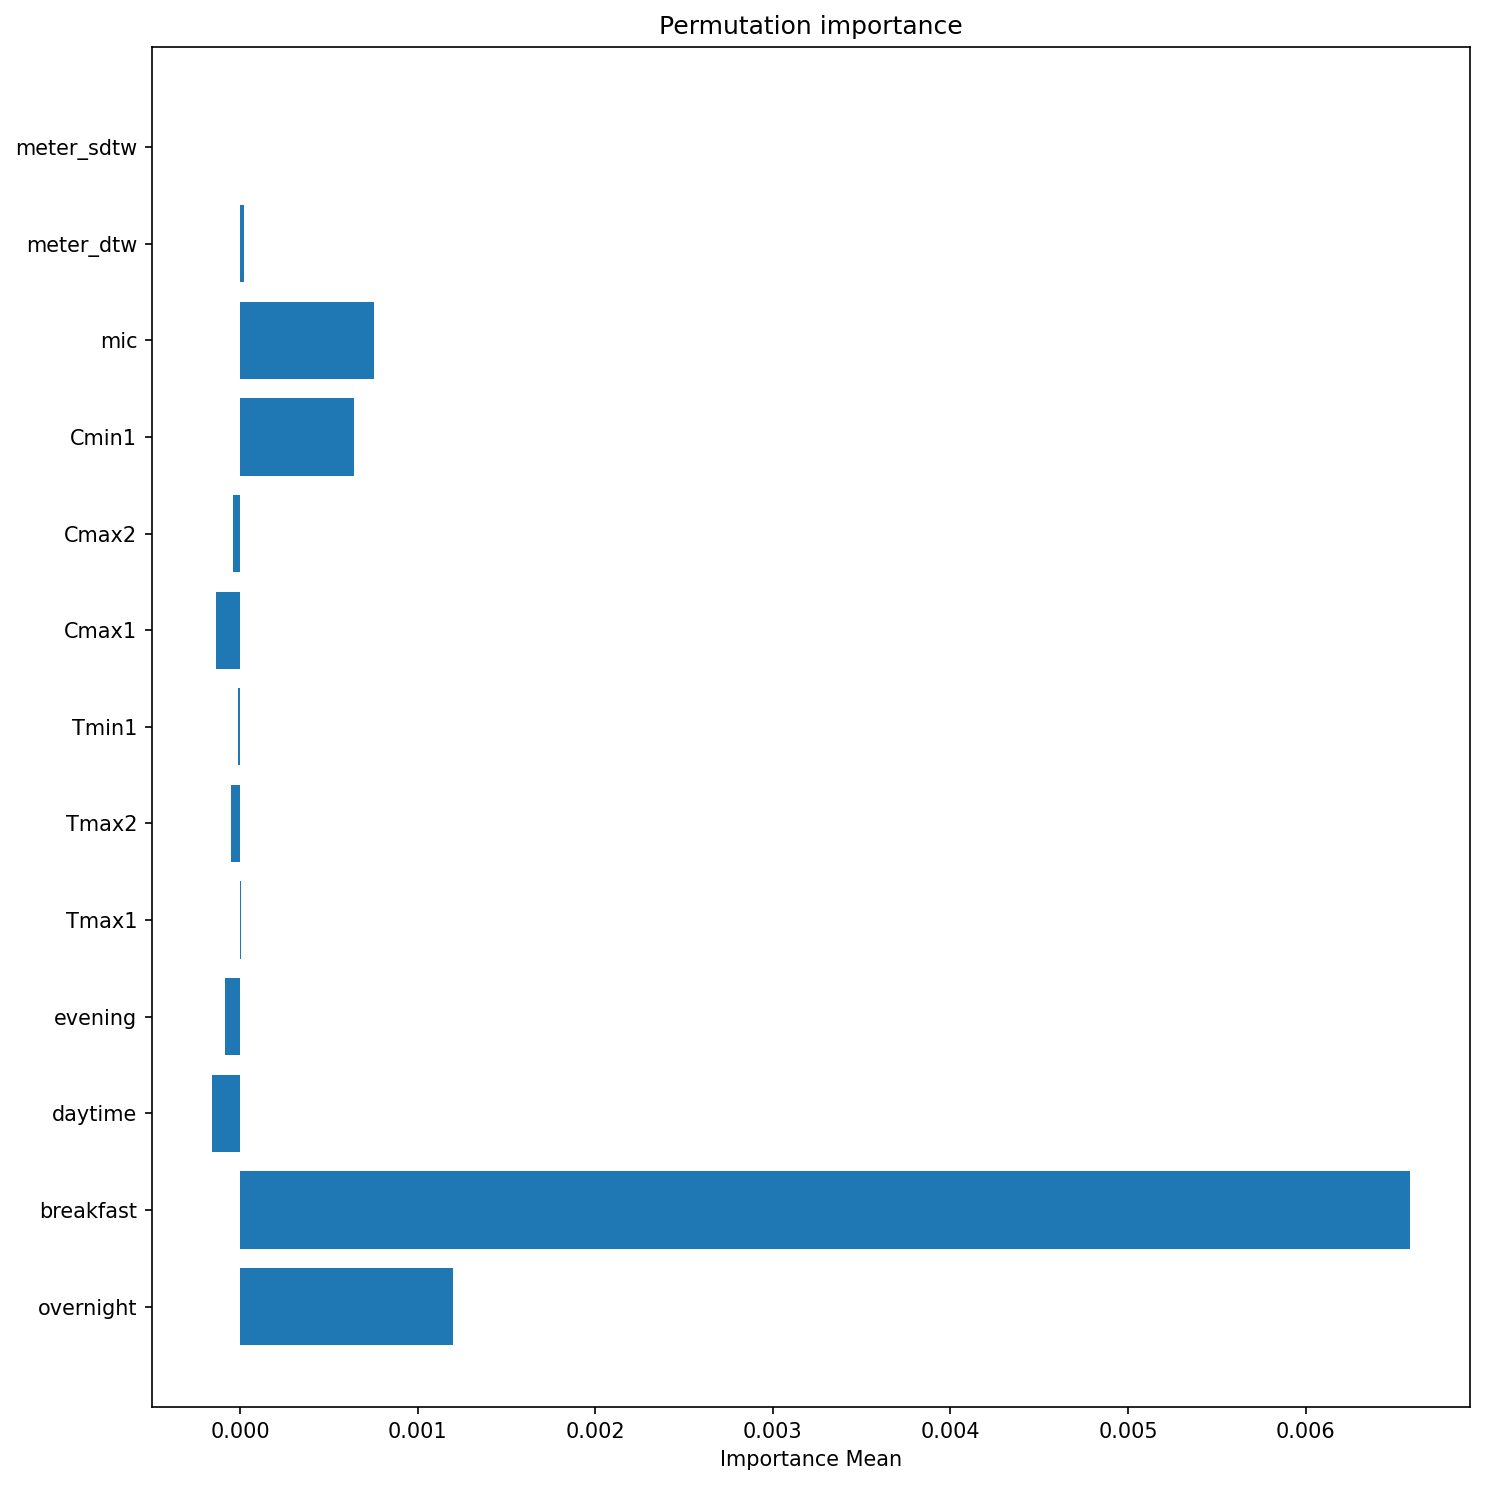

In [41]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "Adaboost: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

save_importance(importance_dict, "adaboost with 13 features", size=(10,10))

In [42]:
# 6:4 and seperate train and test dataset
# Train 4 class of labels
classes = [['meter_dtw', 'meter_sdtw'], ['Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1'], ['overnight', 'breakfast', 'daytime', 'evening'], ['mic']]
for col in classes:
    model, score = train_model(result, col, ['FDI'], return_model=True)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


average_precision_score: 0.0
average_recall_score: 0.0
average_accuracy_score: 0.9502369668246445
average_roc_auc_score: 0.5
average_f1_score: 0.0
average_precision_score: 0.5582078598795103
average_recall_score: 0.08983062127716217
average_accuracy_score: 0.9511676122156315
average_roc_auc_score: 0.5430528284791997
average_f1_score: 0.15473992057263555
average_precision_score: 0.838763832418374
average_recall_score: 0.1271921067518552
average_accuracy_score: 0.9553120477179317
average_roc_auc_score: 0.5629360158387433
average_f1_score: 0.22074657532944708


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


average_precision_score: 0.0
average_recall_score: 0.0
average_accuracy_score: 0.9502369668246445
average_roc_auc_score: 0.5
average_f1_score: 0.0


average_precision_score: 0.8553377214977128
average_recall_score: 0.1507603740308143
average_accuracy_score: 0.9564699726105431
average_roc_auc_score: 0.5747123074480781
average_f1_score: 0.25633220056221606
no origin data
Saving figure Permutation importance: Adaboost: 13 features with 0.4 test data


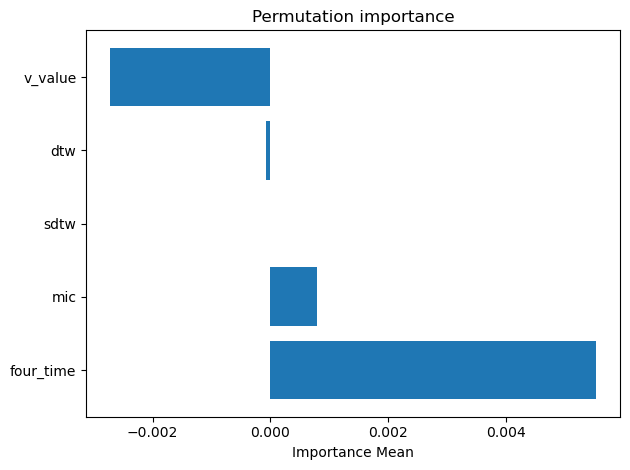

In [13]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "Adaboost: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, save=True)

## old(all meter is false)

average_precision_score: 0.8208937799996697
average_recall_score: 0.07391600945060063
average_accuracy_score: 0.9062254712013273
average_roc_auc_score: 0.5360667895279778
average_f1_score: 0.13562007845745744
no origin data
Saving figure Permutation importance: Adaboost: 13 features with 0.4 test data


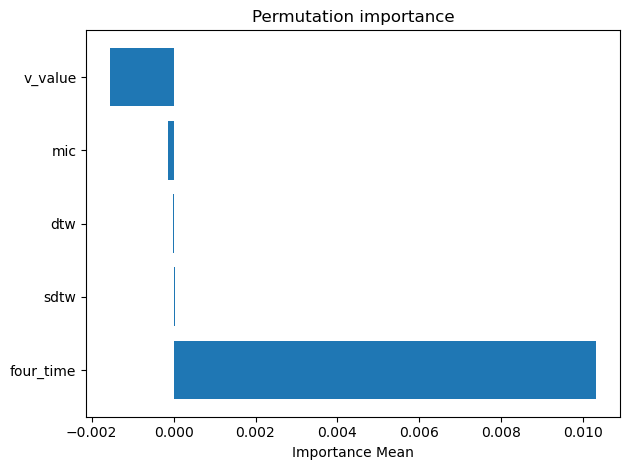

In [16]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "Adaboost: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, save=True)

average_precision_score: 0.8563234427655081
average_recall_score: 0.08503460783334997
average_accuracy_score: 0.9075162862943422
average_roc_auc_score: 0.5417283819261641
average_f1_score: 0.15470545102250852
include origin data
Saving figure Permutation importance: Adaboost: 13 + 48 features with 0.4 test data


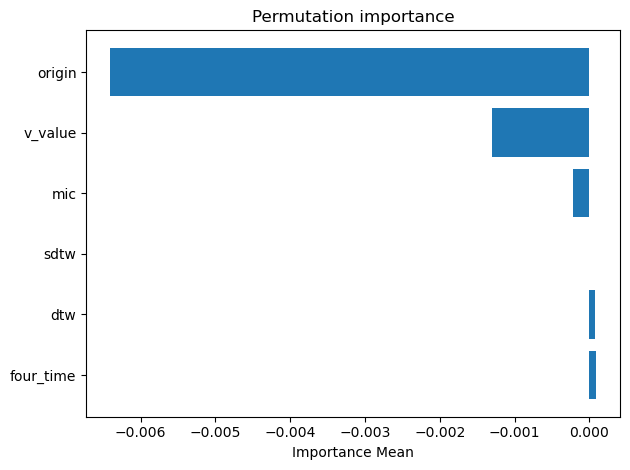

In [18]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "Adaboost: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True, save=True)